In [1]:
import pickle
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from stop_words import get_stop_words
import Stemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import linear_model as lm
from sklearn import ensemble
from sklearn import metrics
from sklearn.decomposition import RandomizedPCA
from sklearn.manifold import TSNE
import xgboost as xgb 
from gensim import corpora, models
from segtok import segmenter
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import glob
from collections import defaultdict
import copy
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD
from gensim.models import word2vec
import config
%matplotlib inline

Using Theano backend.


In [42]:
X_train_Tfidf = pd.read_csv('features/X_train_Tfidf.csv.gz')
X_test_Tfidf = pd.read_csv('features/X_test_Tfidf.csv.gz')
X_train_lda = pd.read_csv('features/X_train_lda.csv.gz')
X_test_lda = pd.read_csv('features/X_test_lda.csv.gz')
X_train_word2vec = pd.read_csv('features/X_train_word2vec.csv.gz')
X_test_word2vec = pd.read_csv('features/X_test_word2vec.csv.gz')
y_train = pd.read_csv('features/y_train.csv.gz')
y_test = pd.read_csv('features/y_test.csv.gz')

In [28]:
X_train_Tfidf.columns = ['tfidf_{}'.format(i) for i in range(1000)]
X_test_Tfidf.columns = ['tfidf_{}'.format(i) for i in range(1000)]
X_train_lda.columns = ['lda_{}'.format(i) for i in range(100)]
X_test_lda.columns = ['lda_{}'.format(i) for i in range(100)]
X_train_word2vec.columns = ['word2vec_{}'.format(i) for i in range(200)]
X_test_word2vec.columns = ['word2vec{}'.format(i) for i in range(200)]

In [103]:
X_train = pd.concat([X_train_Tfidf, X_train_lda, X_train_word2vec, y_train], axis=1)
X_test = pd.concat([X_test_Tfidf, X_test_lda, X_test_word2vec, y_test], axis=1)

In [104]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [105]:
y_train = X_train['y']
y_test = X_test['y']

In [106]:
X_train.drop('y', inplace=True, axis=1)
X_test.drop('y', inplace=True, axis=1)

In [107]:
lr = lm.LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
lr.score(X_test, y_test)

0.42297587771674228

In [91]:
rf = ensemble.GradientBoostingClassifier(n_estimators=600)
rf.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [88]:
rf.score(X_test, y_test)

0.42154287079054215

In [109]:
y_train_cat = np_utils.to_categorical(y_train, 3)
y_test_cat = np_utils.to_categorical(y_test, 3)

In [138]:
model = Sequential()
model.add(Dense(512, input_shape=(1300,)))
model.add(Activation(PReLU()))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation(PReLU()))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [141]:
%%time
history = model.fit(X_train.values, y_train_cat,
                    nb_epoch=6, batch_size=512,
                    verbose=1, validation_split=0.1, )

Train on 15071 samples, validate on 1675 samples
Epoch 1/6
15071/15071 [==============================] - 2s - loss: 1.0362 - acc: 0.4531 - val_loss: 1.0448 - val_acc: 0.4340
Epoch 2/6
15071/15071 [==============================] - 2s - loss: 1.0284 - acc: 0.4655 - val_loss: 1.0456 - val_acc: 0.4281
Epoch 3/6
15071/15071 [==============================] - 2s - loss: 1.0196 - acc: 0.4681 - val_loss: 1.0459 - val_acc: 0.4316
Epoch 4/6
15071/15071 [==============================] - 2s - loss: 1.0102 - acc: 0.4773 - val_loss: 1.0421 - val_acc: 0.4478
Epoch 5/6
15071/15071 [==============================] - 2s - loss: 1.0007 - acc: 0.4881 - val_loss: 1.0388 - val_acc: 0.4478
Epoch 6/6
15071/15071 [==============================] - 2s - loss: 0.9908 - acc: 0.4990 - val_loss: 1.0437 - val_acc: 0.4328
CPU times: user 30.9 s, sys: 27.2 s, total: 58 s
Wall time: 15.9 s


In [142]:
score = model.evaluate(X_test.values, y_test_cat,
                       batch_size=512, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

4096/4187 [============================>.] - ETA: 0sTest score: 1.0629300278
Test accuracy: 0.42751373309


In [144]:
pred = model.predict_classes(X_test.values, batch_size=512)

4187/4187 [==============================] - 0s     


In [154]:
metrics.accuracy_score(y_test, np.ones_like(y_test))

0.34845951755433485

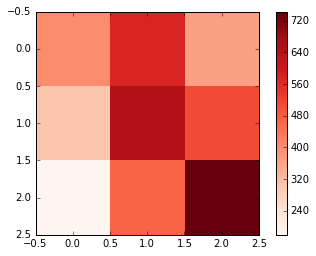

In [145]:
matr = metrics.confusion_matrix(y_test, pred)
plt.imshow(matr, interpolation='nearest', cmap=plt.cm.Reds)
plt.colorbar()